# Footprint prediction output

| Author | Affiliation | Date 
| ---------------- | ---------------- | ---------------- 
| Paul Montesano, PhD | Innovation Lab ; NASA Goddard Space Flight Center | Jan. 2024 

In [1]:
import geopandas as gpd
import pandas as pd
import os, sys
sys.path.append('/home/pmontesa/code/geoscitools')
import footprintlib
import geoscilib

import matplotlib.pyplot as plt
import contextily as ctx
import re
import fiona
import math
import glob

/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel-current/lib/python3.12/site-packages/osgeo/osr.py:410: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [2]:
import importlib
import footprintlib
importlib.reload(footprintlib)

<module 'footprintlib' from '/home/pmontesa/code/geoscitools/footprintlib.py'>

In [3]:
from multiprocessing import Pool
from functools import partial

### Landcover predictions

In [4]:
d_LCvhr = {
    'MAINDIR': '/explore/nobackup/projects/ilab/projects/ABoVE-Shrubs/development',
    #RUNNAME = 'landcover_test_chm_std_global_focalloss' # 4-band + CHM + focal loss --> IGNORE THIS, it sucks - need to find better loss fun
    'RUNNAME': 'landcover_test_chm_std_local', #  4-band + CHM
    #RUNNAME = '...' # start with self-supervised pre-trained foundation model
    'TARGET': 'sr-02m.landcover.tif',
    'TYPE_NAME': "$LC_{SR}$",
    'SPLIT_STR': '-sr'
}
d_LCvhr['OUTDIR']=f"{d_LCvhr['MAINDIR']}/{d_LCvhr['RUNNAME']}/predictions"
d_LCvhr['TARGET_DIR']=f"{d_LCvhr['OUTDIR']}/002m" # predictions dir

print(f"Target dir to be footprinted:\n\t{d_LCvhr['TARGET_DIR']}")
# output footprints filename
OUT_FOOT_FN = os.path.join(os.path.dirname(d_LCvhr['MAINDIR']), 'footprints', f"footprints_{d_LCvhr['RUNNAME']}.gpkg")
print(f'Footprint will be here:\n\t{OUT_FOOT_FN}')

Target dir to be footprinted:
	/explore/nobackup/projects/ilab/projects/ABoVE-Shrubs/development/landcover_test_chm_std_local/predictions/002m
Footprint will be here:
	/explore/nobackup/projects/ilab/projects/ABoVE-Shrubs/footprints/footprints_landcover_test_chm_std_local.gpkg


In [5]:
d_LCvhr_v10 = {
    'MAINDIR': '/explore/nobackup/projects/above/misc/ABoVE_Shrubs',
    'RUNNAME': 'development/landcover/v1', #  4-band + CHM
    'SEARCH_STRING': '/*landcover.tif',
    'TYPE_NAME': "$LC_{SR}$",
    'SPLIT_STR': '-sr'
}
d_LCvhr_v10['TARGET_DIR']=f"{d_LCvhr_v10['MAINDIR']}/{d_LCvhr_v10['RUNNAME']}"

print(f"Target dir to be footprinted:\n\t{d_LCvhr_v10['TARGET_DIR']}")
# output footprints filename
d_LCvhr_v10['OUT_FOOT_FN'] = os.path.join(d_LCvhr_v10['MAINDIR'], 'footprints', f"footprints_{d_LCvhr_v10['RUNNAME'].replace('/','_')}.gpkg")
print(f"Footprint will be here:\n\t{d_LCvhr_v10['OUT_FOOT_FN']}")

# Get footprints gdf from a target dir
print(f"{d_LCvhr_v10['TARGET_DIR']}{d_LCvhr_v10['SEARCH_STRING']}")

d_LCvhr_v10['f_list'] = glob.glob(f"{d_LCvhr_v10['TARGET_DIR']}{d_LCvhr_v10['SEARCH_STRING']}", recursive=True)
print(f"Search returned {len(d_LCvhr_v10['f_list'])}")

Target dir to be footprinted:
	/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/landcover/v1
Footprint will be here:
	/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_development_landcover_v1.gpkg
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/landcover/v1/*landcover.tif
Search returned 3511


In [6]:
d_LCvhr_v11 = {
    'MAINDIR': '/explore/nobackup/projects/above/misc/ABoVE_Shrubs',
    'RUNNAME': 'development/landcover/v1.1', #  4-band + CHM
    'SEARCH_STRING': '/*landcover.tif',
    'TYPE_NAME': "$LC_{SR}$",
    'SPLIT_STR': '-sr'
}
d_LCvhr_v11['TARGET_DIR']=f"{d_LCvhr_v11['MAINDIR']}/{d_LCvhr_v11['RUNNAME']}"

print(f"Target dir to be footprinted:\n\t{d_LCvhr_v11['TARGET_DIR']}")
# output footprints filename
d_LCvhr_v11['OUT_FOOT_FN'] = os.path.join(d_LCvhr_v11['MAINDIR'], 'footprints', f"footprints_{d_LCvhr_v11['RUNNAME'].replace('/','_')}.gpkg")
print(f"Footprint will be here:\n\t{d_LCvhr_v11['OUT_FOOT_FN']}")

# Get footprints gdf from a target dir
print(f"{d_LCvhr_v11['TARGET_DIR']}{d_LCvhr_v11['SEARCH_STRING']}")

d_LCvhr_v11['f_list'] = glob.glob(f"{d_LCvhr_v11['TARGET_DIR']}{d_LCvhr_v11['SEARCH_STRING']}", recursive=True)
print(f"Search returned {len(d_LCvhr_v11['f_list'])}")

Target dir to be footprinted:
	/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/landcover/v1.1
Footprint will be here:
	/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_development_landcover_v1.1.gpkg
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/landcover/v1.1/*landcover.tif
Search returned 1573


### CHM predictions

In [7]:
d_CHMvhr_v10 = {
    'MAINDIR': '/explore/nobackup/projects/above/misc/ABoVE_Shrubs', # /explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v2/dinov2-chm-v1
 
    'RUNNAME': 'development/chm/v1',#'chm_2024', #'chm/v2/dinov2-chm-v1', #'chm/20231014_chm/002m',
    'SEARCH_STRING': '/*.cnn-chm-v1.tif', #'/*-sr-02m.chm.tif', #'/**/*-sr-02m.cnn-chm-v1.tif',
    'TYPE_NAME': "$CHM_{SR}$",
    'SPLIT_STR': '-sr'
}
d_CHMvhr_v10['TARGET_DIR']=f"{d_CHMvhr_v10['MAINDIR']}/{d_CHMvhr_v10['RUNNAME']}*"

print(f"Target dir to be footprinted:\n\t{d_CHMvhr_v10['TARGET_DIR']}")
# output footprints filename
d_CHMvhr_v10['OUT_FOOT_FN'] = os.path.join(d_CHMvhr_v10['MAINDIR'], 'footprints', f"footprints_{d_CHMvhr_v10['RUNNAME'].replace('/','_')}.gpkg")
print(f"Footprint will be here:\n\t{d_CHMvhr_v10['OUT_FOOT_FN']}")

# Get footprints gdf from a target dir
print(f"{d_CHMvhr_v10['TARGET_DIR']}{d_CHMvhr_v10['SEARCH_STRING']}")

d_CHMvhr_v10['f_list'] = glob.glob(f"{d_CHMvhr_v10['TARGET_DIR']}{d_CHMvhr_v10['SEARCH_STRING']}", recursive=True)
print(f"Search returned {len(d_CHMvhr_v10['f_list'])}")

Target dir to be footprinted:
	/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v1*
Footprint will be here:
	/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_development_chm_v1.gpkg
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v1*/*.cnn-chm-v1.tif
Search returned 1601


In [8]:
d_CHMvhr_v22 = {
    'MAINDIR': '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development', # /explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v2/dinov2-chm-v1
 
    'RUNNAME': 'chm/v2/dinov2-chm-v1', 
    'SEARCH_STRING': '/*-sr-02m.chm.tif', 
    'TYPE_NAME': "$CHM_{SR}$",
    'SPLIT_STR': '-sr'
}
d_CHMvhr_v22['TARGET_DIR']=f"{d_CHMvhr_v22['MAINDIR']}/{d_CHMvhr_v22['RUNNAME']}*"

print(f"Target dir to be footprinted:\n\t{d_CHMvhr_v22['TARGET_DIR']}")
# output footprints filename
d_CHMvhr_v22['OUT_FOOT_FN'] = os.path.join(os.path.dirname(d_CHMvhr_v22['MAINDIR']), 'footprints', f"footprints_{d_CHMvhr_v22['RUNNAME'].replace('/','_')}.gpkg")
print(f"Footprint will be here:\n\t{d_CHMvhr_v22['OUT_FOOT_FN']}")

# Get footprints gdf from a target dir
print(f"{d_CHMvhr_v22['TARGET_DIR']}{d_CHMvhr_v22['SEARCH_STRING']}")

d_CHMvhr_v22['f_list'] = glob.glob(f"{d_CHMvhr_v22['TARGET_DIR']}{d_CHMvhr_v22['SEARCH_STRING']}", recursive=True)
print(f"Search returned {len(d_CHMvhr_v22['f_list'])}")

Target dir to be footprinted:
	/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v2/dinov2-chm-v1*
Footprint will be here:
	/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_chm_v2_dinov2-chm-v1.gpkg
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v2/dinov2-chm-v1*/*-sr-02m.chm.tif
Search returned 10


In [9]:
d_CHMvhr_unet151 = {
    'MAINDIR': '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development', # /explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v2/dinov2-chm-v1
 
    'RUNNAME': 'chm/custom_unet/1.5.1', 
    'SEARCH_STRING': '/*-sr-02m.chm.tif', 
    'TYPE_NAME': "$CHM_{SR}$",
    'SPLIT_STR': '-sr'
}
d_CHMvhr_unet151['TARGET_DIR']=f"{d_CHMvhr_unet151['MAINDIR']}/{d_CHMvhr_unet151['RUNNAME']}*"

print(f"Target dir to be footprinted:\n\t{d_CHMvhr_unet151['TARGET_DIR']}")
# output footprints filename
d_CHMvhr_unet151['OUT_FOOT_FN'] = os.path.join(os.path.dirname(d_CHMvhr_unet151['MAINDIR']), 'footprints', f"footprints_{d_CHMvhr_unet151['RUNNAME'].replace('/','_')}.gpkg")
print(f"Footprint will be here:\n\t{d_CHMvhr_unet151['OUT_FOOT_FN']}")

# Get footprints gdf from a target dir
print(f"{d_CHMvhr_unet151['TARGET_DIR']}{d_CHMvhr_unet151['SEARCH_STRING']}")

d_CHMvhr_unet151['f_list'] = glob.glob(f"{d_CHMvhr_unet151['TARGET_DIR']}{d_CHMvhr_unet151['SEARCH_STRING']}", recursive=True)
print(f"Search returned {len(d_CHMvhr_unet151['f_list'])}")

Target dir to be footprinted:
	/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/custom_unet/1.5.1*
Footprint will be here:
	/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_chm_custom_unet_1.5.1.gpkg
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/custom_unet/1.5.1*/*-sr-02m.chm.tif
Search returned 75


In [10]:
d_CHMvhr_unet152 = {
    'MAINDIR': '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development', # /explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v2/dinov2-chm-v1
 
    'RUNNAME': 'chm/custom_unet/1.5.2', 
    'SEARCH_STRING': '/*-sr-02m.chm.tif', 
    'TYPE_NAME': "$CHM_{SR}$",
    'SPLIT_STR': '-sr'
}
d_CHMvhr_unet152['TARGET_DIR']=f"{d_CHMvhr_unet152['MAINDIR']}/{d_CHMvhr_unet152['RUNNAME']}*"

print(f"Target dir to be footprinted:\n\t{d_CHMvhr_unet151['TARGET_DIR']}")
# output footprints filename
d_CHMvhr_unet152['OUT_FOOT_FN'] = os.path.join(os.path.dirname(d_CHMvhr_unet152['MAINDIR']), 'footprints', f"footprints_{d_CHMvhr_unet152['RUNNAME'].replace('/','_')}.gpkg")
print(f"Footprint will be here:\n\t{d_CHMvhr_unet152['OUT_FOOT_FN']}")

# Get footprints gdf from a target dir
print(f"{d_CHMvhr_unet152['TARGET_DIR']}{d_CHMvhr_unet152['SEARCH_STRING']}")

d_CHMvhr_unet152['f_list'] = glob.glob(f"{d_CHMvhr_unet152['TARGET_DIR']}{d_CHMvhr_unet152['SEARCH_STRING']}", recursive=True)
print(f"Search returned {len(d_CHMvhr_unet152['f_list'])}")

Target dir to be footprinted:
	/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/custom_unet/1.5.1*
Footprint will be here:
	/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_chm_custom_unet_1.5.2.gpkg
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/custom_unet/1.5.2*/*-sr-02m.chm.tif
Search returned 23


In [14]:
d_CHMvhr_dinov3 = {
    # Structure for development work
    # 'MAINDIR': '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/development', # /explore/nobackup/projects/above/misc/ABoVE_Shrubs/development/chm/v2/dinov2-chm-v1
    # 'RUNNAME': 'chm/dinov3/2.3.2.1', 
    # Structure for final chms
    'MAINDIR': '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm',
    'RUNNAME': '2026_chm/4.3.2.5/dm_10m',
    'SEARCH_STRING': '/*.tif', 
    'TYPE_NAME': "$CHM_{SR}$",
    'SPLIT_STR': '-sr'
}

dict_list_d_CHMvhr_dinov3 = []

for RUNNAME in [
    #'chm/dinov3/2.3.2.1', # 50k
                #'chm/dinov3/3.3.2.2','chm/dinov3/3.3.2.3','chm/dinov3/3.3.2.4',  # 100k training dataset mae, mse, customloss
                #'chm/dinov3/4.3.2.2',
                #'chm/dinov3/4.3.2.3',
                #'chm/dinov3/4.3.2.4'
                #'chm/dinov3/4.3.2.5' # full training dataset w/ custom loss function
                '2026_chm/4.3.2.5/dm_10m'
]: # 342k (full set of training chips) dataset mae, mse, customloss
    
    d = d_CHMvhr_dinov3.copy()
    
    d['RUNNAME'] = RUNNAME
    d['TARGET_DIR']=f"{d['MAINDIR']}/{d['RUNNAME']}"
    
    print(f"Target dir to be footprinted:\n\t{d['TARGET_DIR']}")

    # output footprints filename
    d['OUT_FOOT_FN'] = os.path.join(os.path.dirname(d['MAINDIR']), 'footprints', f"footprints_{d['RUNNAME'].replace('/','_')}.gpkg")
    print(f"Footprint will be here:\n\t{d['OUT_FOOT_FN']}")
    
    # Get footprints gdf from a target dir
    #print(f"{d['TARGET_DIR']}{d['SEARCH_STRING']}")
    
    d['f_list'] = glob.glob(f"{d['TARGET_DIR']}{d['SEARCH_STRING']}", recursive=True)
    print(f"Search returned {len(d['f_list'])}\n")

    dict_list_d_CHMvhr_dinov3.append(d)

Target dir to be footprinted:
	/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m
Footprint will be here:
	/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_2026_chm_4.3.2.5_dm_10m.gpkg
Search returned 3219



## Build list of files to footprint

In [15]:
dict_list_d_CHMvhr_dinov3

[{'MAINDIR': '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm',
  'RUNNAME': '2026_chm/4.3.2.5/dm_10m',
  'SEARCH_STRING': '/*.tif',
  'TYPE_NAME': '$CHM_{SR}$',
  'SPLIT_STR': '-sr',
  'TARGET_DIR': '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m',
  'OUT_FOOT_FN': '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_2026_chm_4.3.2.5_dm_10m.gpkg',
  'f_list': ['/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV02_20170515_M1BS_103001006944DA00-chm-dm-10m.tif',
   '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV03_20190830_M1BS_1040010050394100-chm-dm-10m.tif',
   '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV02_20160623_M1BS_103001005871E600-chm-dm-10m.tif',
   '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV03_20190428_M1BS_104001004B223A00-chm-dm-10m.tif',
   '/explore/nobackup/projects/abov

In [16]:
d = dict_list_d_CHMvhr_dinov3[0]

In [17]:
d['f_list'][0:4]

['/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV02_20170515_M1BS_103001006944DA00-chm-dm-10m.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV03_20190830_M1BS_1040010050394100-chm-dm-10m.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV02_20160623_M1BS_103001005871E600-chm-dm-10m.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV03_20190428_M1BS_104001004B223A00-chm-dm-10m.tif']

# Footprint

In [18]:
# %%time
# with Pool(processes=35) as pool:
#     f_gdf_lst = pool.map(partial(footprintlib.raster_footprint, DO_DATAMASK=False, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True), d['f_list'])

In [19]:
# footprint_gdf = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=d['TARGET_DIR'], DROP_DUPLICATES=True)
# footprint_gdf = footprintlib.get_attributes_from_filename(footprint_gdf, d['TYPE_NAME'], d['SPLIT_STR'])

# footprint_gdf['year_cat'] = footprint_gdf.year.astype(str)
# footprint_gdf['month_cat'] = footprint_gdf.month.astype(str)

# footprint_gdf.to_file(OUT_FOOT_FN, driver='GPKG')

# footprint_gdf.info()

In [20]:
def footprint_gpkg_wrapper(f_list, d, OUT_FOOT_FN, WRITE_GPKG=False):
    
    with Pool(processes=1) as pool:
        f_gdf_lst = pool.map(partial(footprintlib.raster_footprint, DO_DATAMASK=False, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True), f_list)
        
    footprint_gdf = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=d['TYPE_NAME'], DROP_DUPLICATES=True)
    footprint_gdf = footprintlib.get_attributes_from_filename(footprint_gdf, d['TYPE_NAME'], d['SPLIT_STR'])

    footprint_gdf['year_cat'] = footprint_gdf.year.astype(str)
    footprint_gdf['month_cat'] = footprint_gdf.month.astype(str)
    print(footprint_gdf.shape)
    
    if WRITE_GPKG:
        print(d['OUT_FOOT_FN'])
        footprint_gdf.to_file(OUT_FOOT_FN, driver='GPKG')
    
    return footprint_gdf

In [21]:
dict_list_d_CHMvhr_dinov3

[{'MAINDIR': '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm',
  'RUNNAME': '2026_chm/4.3.2.5/dm_10m',
  'SEARCH_STRING': '/*.tif',
  'TYPE_NAME': '$CHM_{SR}$',
  'SPLIT_STR': '-sr',
  'TARGET_DIR': '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m',
  'OUT_FOOT_FN': '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_2026_chm_4.3.2.5_dm_10m.gpkg',
  'f_list': ['/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV02_20170515_M1BS_103001006944DA00-chm-dm-10m.tif',
   '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV03_20190830_M1BS_1040010050394100-chm-dm-10m.tif',
   '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV02_20160623_M1BS_103001005871E600-chm-dm-10m.tif',
   '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV03_20190428_M1BS_104001004B223A00-chm-dm-10m.tif',
   '/explore/nobackup/projects/abov

In [22]:
%%time
footprint_gdf_list = []
for d in dict_list_d_CHMvhr_dinov3:
    if len(d['f_list']) > 0:
        footprint_gdf_list.append(footprint_gpkg_wrapper(d['f_list'], d, d['OUT_FOOT_FN'], WRITE_GPKG=True))

Building GDF from list...
(3219, 14)
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_2026_chm_4.3.2.5_dm_10m.gpkg
CPU times: user 962 ms, sys: 58.3 ms, total: 1.02 s
Wall time: 37.3 s


In [ ]:
#footprint_gdf = footprint_gdf_list[0]

## Read, map

In [19]:
#footprint_gdf = gpd.read_file(d_CHMvhr_v10['OUT_FOOT_FN'])
footprint_gdf = gpd.read_file('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_chm_dinov3_4.3.2.5.gpkg')

In [20]:
footprint_gdf.shape

(3219, 14)

<Axes: xlabel='date'>

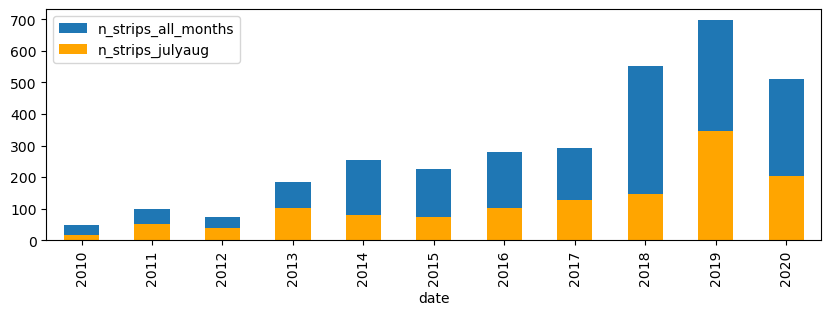

In [21]:
ax = footprint_gdf.\
    groupby([footprint_gdf["date"].dt.year]).\
    aggregate(n_strips_all_months = ('year', 'count')).plot(kind='bar', figsize=(10,3))
footprint_gdf[(footprint_gdf.month == 7) | (footprint_gdf.month == 8)].\
    groupby([footprint_gdf["date"].dt.year]).\
    aggregate(n_strips_julyaug = ('year', 'count')).plot(kind="bar", ax=ax, legend=True, color='orange')

In [22]:
from basemaplib import *

In [23]:
footprint_gdf[(footprint_gdf.month == 7) | (footprint_gdf.month == 8)].drop('date', axis=1).cx[-170:-130,40:75].explore(color='gray', tiles=basemaps['ESRINatGeo'].tiles, attr=' ')